# Classificação de Diabetes com Random Forest

Este notebook implementa um modelo de Random Forest para classificação de diabetes baseado no dataset "diabetes_012_health_indicators_BRFSS2015.csv". O objetivo é prever se um paciente tem diabetes (1) ou não (0) com base em várias características de saúde.

## 1. Pré-processamento dos Dados

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2

# Carregar os dados
df = pd.read_csv('./data/diabetes_012_health_indicators_BRFSS2015.csv')

# Verificar distribuição das classes
print("\nDistribuição original das classes:")
print(df['Diabetes_012'].value_counts(normalize=True))

# Selecionar features
features = [
    'HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity',
    'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth',
    'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income'
]

# Transformar a variável alvo em binária: 1 para pré-diabetes e diabetes, 0 para sem diabetes
df['Diabetes_binary'] = df['Diabetes_012'].replace({2:1})

# Separar conjuntos para classificação
X = df[features]
y = df['Diabetes_binary']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Aplicar SMOTE para balanceamento de classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verificar distribuição das classes após SMOTE
print("\nDistribuição das classes após SMOTE:")
print(pd.Series(y_resampled).value_counts(normalize=True))


Distribuição original das classes:
Diabetes_012
0.0    0.842412
2.0    0.139333
1.0    0.018255
Name: proportion, dtype: float64

Distribuição das classes após SMOTE:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


## 3. Treinamento do Modelo Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Configurar parâmetros para Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2', 'sqrt']
}

# Criar o modelo Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='roc_auc'
)

# Treinar o modelo
print("Iniciando Grid Search...")
grid_search.fit(X_resampled, y_resampled)

# Melhores parâmetros encontrados
print("\nMelhores parâmetros:", grid_search.best_params_)
print("Melhor AUC-ROC:", grid_search.best_score_)

# Usar o melhor modelo
best_rf = grid_search.best_estimator_

Iniciando Grid Search...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Melhores parâmetros: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Melhor AUC-ROC: 0.9710369498876187


## 4. Avaliação do Modelo

MÉTRICAS DO CONJUNTO DE TESTE

Relatório de Classificação:
              precision    recall  f1-score   support

Sem Diabetes       0.87      0.94      0.91     64111
    Diabetes       0.45      0.24      0.31     11993

    accuracy                           0.83     76104
   macro avg       0.66      0.59      0.61     76104
weighted avg       0.80      0.83      0.81     76104


Acurácia: 0.8335961316093766
AUC-ROC: 0.778808960304236
Average Precision: 0.36345268210662396

MÉTRICAS DO CONJUNTO DE TREINO

Relatório de Classificação:
              precision    recall  f1-score   support

Sem Diabetes       0.99      1.00      0.99    149592
    Diabetes       1.00      0.99      0.99    149592

    accuracy                           0.99    299184
   macro avg       0.99      0.99      0.99    299184
weighted avg       0.99      0.99      0.99    299184


Acurácia: 0.9915570351355687
AUC-ROC: 0.9994326109345887
Average Precision: 0.9994961997095568


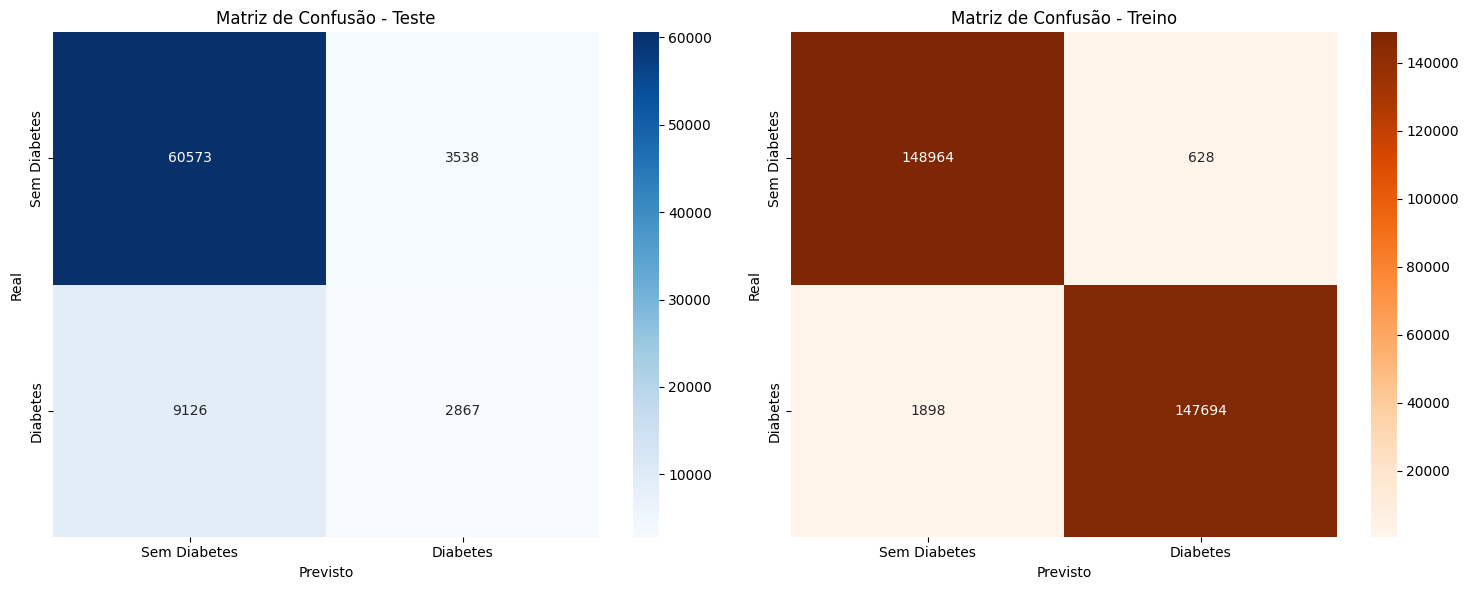

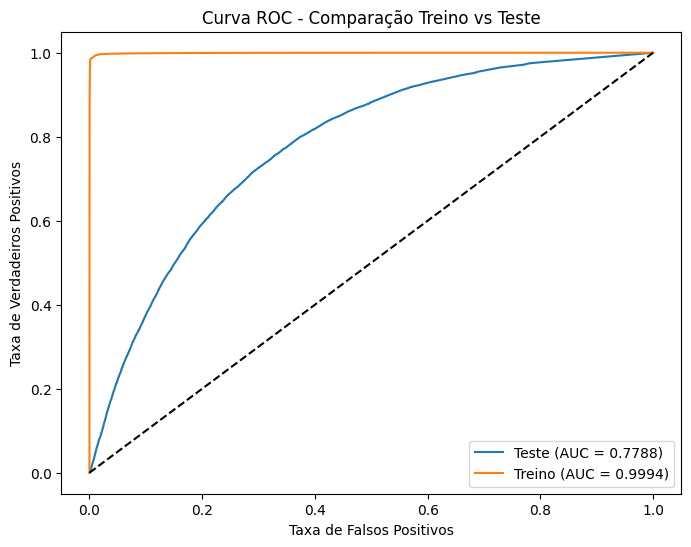

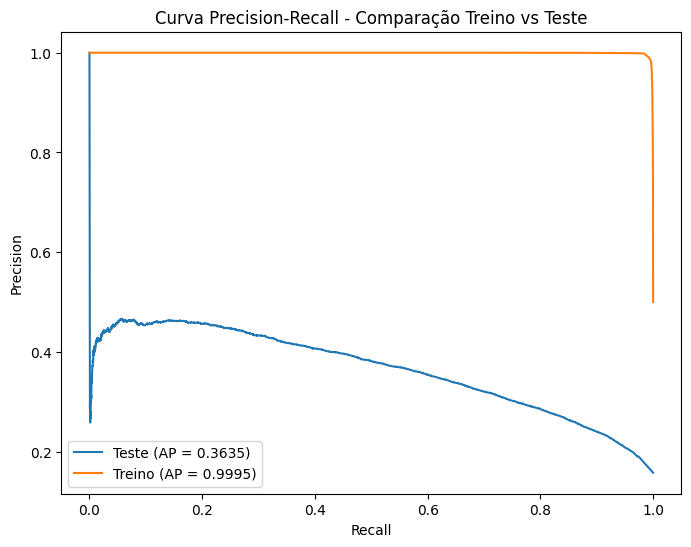

In [7]:
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, roc_curve, accuracy_score,
                            precision_recall_curve, average_precision_score)

# Previsões no conjunto de teste
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Previsões no conjunto de treino
y_train_pred = best_rf.predict(X_resampled)
y_train_pred_proba = best_rf.predict_proba(X_resampled)[:, 1]

# Métricas de avaliação - TESTE
print("=" * 50)
print("MÉTRICAS DO CONJUNTO DE TESTE")
print("=" * 50)
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Sem Diabetes', 'Diabetes']))

print("\nAcurácia:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))
print("Average Precision:", average_precision_score(y_test, y_pred_proba))

# Métricas de avaliação - TREINO
print("\n" + "=" * 50)
print("MÉTRICAS DO CONJUNTO DE TREINO")
print("=" * 50)
print("\nRelatório de Classificação:")
print(classification_report(y_resampled, y_train_pred, target_names=['Sem Diabetes', 'Diabetes']))

print("\nAcurácia:", accuracy_score(y_resampled, y_train_pred))
print("AUC-ROC:", roc_auc_score(y_resampled, y_train_pred_proba))
print("Average Precision:", average_precision_score(y_resampled, y_train_pred_proba))

# Matriz de Confusão - Comparação
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Teste
cm_test = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sem Diabetes', 'Diabetes'],
            yticklabels=['Sem Diabetes', 'Diabetes'],
            ax=axes[0])
axes[0].set_xlabel('Previsto')
axes[0].set_ylabel('Real')
axes[0].set_title('Matriz de Confusão - Teste')

# Treino
cm_train = confusion_matrix(y_resampled, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Sem Diabetes', 'Diabetes'],
            yticklabels=['Sem Diabetes', 'Diabetes'],
            ax=axes[1])
axes[1].set_xlabel('Previsto')
axes[1].set_ylabel('Real')
axes[1].set_title('Matriz de Confusão - Treino')

plt.tight_layout()
plt.show()

# Curva ROC - Comparação
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba)
fpr_train, tpr_train, _ = roc_curve(y_resampled, y_train_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label='Teste (AUC = %0.4f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot(fpr_train, tpr_train, label='Treino (AUC = %0.4f)' % roc_auc_score(y_resampled, y_train_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Comparação Treino vs Teste')
plt.legend(loc='lower right')
plt.show()

# Curva Precision-Recall - Comparação
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba)
precision_train, recall_train, _ = precision_recall_curve(y_resampled, y_train_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_test, precision_test, label='Teste (AP = %0.4f)' % average_precision_score(y_test, y_pred_proba))
plt.plot(recall_train, precision_train, label='Treino (AP = %0.4f)' % average_precision_score(y_resampled, y_train_pred_proba))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Comparação Treino vs Teste')
plt.legend(loc='lower left')
plt.show()

## 5. Importância das Features

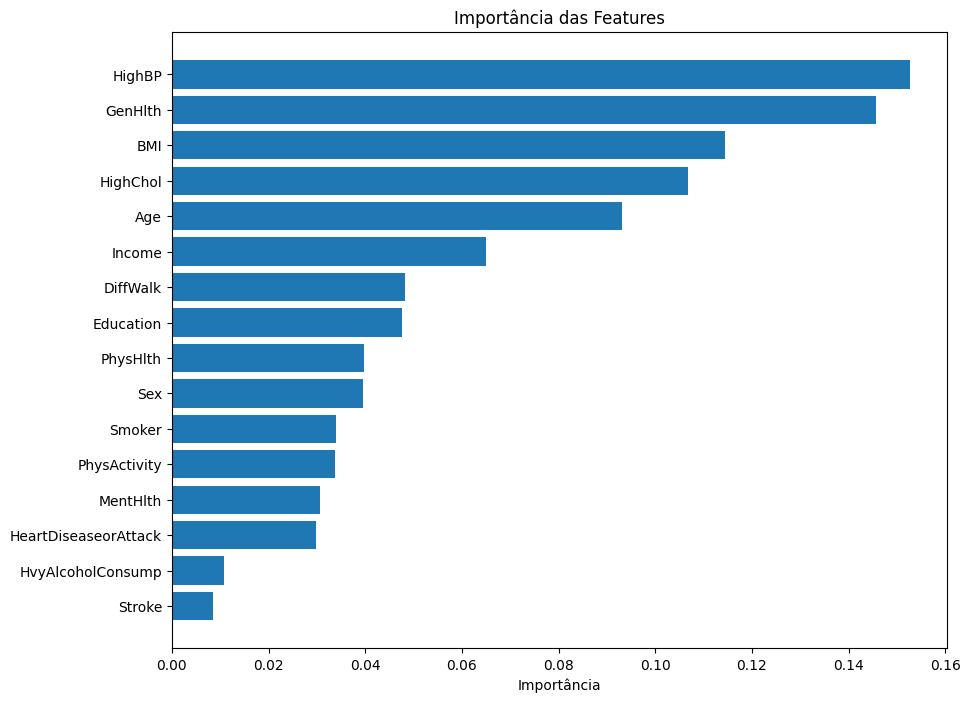


Importância das features:


,Feature,Importance
15,HighBP,0.152683
14,GenHlth,0.145731
13,BMI,0.114397
12,HighChol,0.106871
11,Age,0.093107
10,Income,0.064987
9,DiffWalk,0.048222
8,Education,0.047521
7,PhysHlth,0.039667
6,Sex,0.039443


In [6]:
# Obter importância das features
feature_importance = best_rf.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Criar dataframe com importância das features
importance_df = pd.DataFrame({
    'Feature': selected_features[sorted_idx],
    'Importance': feature_importance[sorted_idx]
})

# Plotar importância das features
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), selected_features[sorted_idx])
plt.xlabel('Importância')
plt.title('Importância das Features')
plt.show()

# Mostrar tabela de importância
print("\nImportância das features:")
display(importance_df.sort_values('Importance', ascending=False))

## 6. Exemplo de Previsões

In [8]:
# Criar dataframe com exemplos reais e previsões
results_df = pd.DataFrame({
    'Real': y_test,
    'Previsto': y_pred,
    'Probabilidade_Diabetes': y_pred_proba
})

# Juntar com as features originais para análise
results_df = pd.concat([X_test.reset_index(drop=True), results_df], axis=1)

# Mostrar exemplos onde o modelo errou
print("Exemplos de erros de classificação:")
display(results_df[results_df['Real'] != results_df['Previsto']].head(10))

# Mostrar exemplos com alta probabilidade mas classe errada
print("\nExemplos com alta confiança mas previsão errada:")
display(results_df[((results_df['Probabilidade_Diabetes'] > 0.8) & (results_df['Real'] == 0)) |
                  ((results_df['Probabilidade_Diabetes'] < 0.2) & (results_df['Real'] == 1))].head(10))

Exemplos de erros de classificação:


,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Real,Previsto,Probabilidade_Diabetes
0,1.0,1.0,39.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,6.0,6.0,0.0,0.0,8.0,4.0,2.0,NaN,NaN,NaN
1,1.0,1.0,32.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,30.0,1.0,0.0,7.0,4.0,3.0,NaN,NaN,NaN
2,0.0,0.0,20.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,5.0,4.0,3.0,0.0,1.0,0.515
3,0.0,0.0,18.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,30.0,14.0,0.0,0.0,5.0,6.0,8.0,NaN,NaN,NaN
4,1.0,1.0,32.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,6.0,2.0,0.0,0.0,8.0,5.0,8.0,NaN,NaN,NaN
6,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,5.0,6.0,6.0,NaN,NaN,NaN
7,1.0,1.0,30.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,5.0,30.0,1.0,1.0,6.0,6.0,7.0,NaN,NaN,NaN
8,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,11.0,4.0,3.0,NaN,NaN,NaN
9,1.0,1.0,37.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,12.0,4.0,4.0,NaN,NaN,NaN
10,1.0,1.0,34.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,10.0,0.0,1.0,8.0,4.0,8.0,NaN,NaN,NaN



Exemplos com alta confiança mas previsão errada:


,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Real,Previsto,Probabilidade_Diabetes
23,1.0,1.0,28.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,7.0,1.0,1.0,10.0,3.0,4.0,1.0,0.0,0.001667
34,0.0,0.0,37.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2.0,3.0,4.0,1.0,0.0,0.090000
68,1.0,0.0,30.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,13.0,5.0,5.0,1.0,0.0,0.140000
92,1.0,1.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,30.0,1.0,1.0,13.0,6.0,8.0,1.0,0.0,0.048958
137,1.0,1.0,33.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,2.0,0.0,0.0,13.0,5.0,2.0,1.0,0.0,0.085667
143,0.0,0.0,22.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,4.0,6.0,8.0,1.0,0.0,0.068929
144,0.0,0.0,33.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,6.0,5.0,7.0,1.0,0.0,0.025000
152,0.0,1.0,29.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,8.0,6.0,8.0,1.0,0.0,0.178452
377,1.0,1.0,22.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,30.0,1.0,0.0,7.0,4.0,4.0,1.0,0.0,0.090000
441,0.0,0.0,19.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,3.0,0.0,1.0,11.0,5.0,7.0,1.0,0.0,0.185000


## 7. Conclusão

O modelo Random Forest foi treinado com sucesso para classificar pacientes com diabetes. As principais métricas e visualizações mostram o desempenho do modelo e quais features são mais relevantes para a previsão.

**Próximos passos possíveis:**
- Experimentar outros modelos (XGBoost, SVM, etc.)
- Ajustar ainda mais os hiperparâmetros
- Coletar mais dados para melhorar o balanceamento das classes
- Engenharia de features adicionais